## Optimization with Temporal and Logical Specifications via Generalized Mean-based Smooth Robustness Measures (D-GMSR)

<img src="sim/rocket_landing.gif" width="1600" align="center">

## User input

In [1]:
save_fig = True
rl_animations = False
fig_format = ['pdf', 'png'][0]
fig_png_dpi = 600
run_list = [' ',
            # 'verify', 
            # 'how_it_works', 
            # 'locality_masking', 
            'run_nonlinear_double_integrator', 
            'run_quadrotor_flight', 
            'run_rocket_landing',
            ]

## Libraries

In [2]:
import numpy as np
import cvxpy as cp
import sympy as sp

import os
import glob
import warnings
import typing as T
from tqdm import tqdm
from PIL import Image
from itertools import groupby, count

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mpl.rcParams["figure.dpi"] = 120
mpl.rc(
    "font", **{"family": "serif", "sans-serif": ["Computer Modern Roman"]}
)  ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc("text", usetex=True)
mpl.rcParams["axes.prop_cycle"] = cycler(
    color=["tab:red", "k", "tab:green", "tab:blue", "tab:grey"]
)
mpl.rcParams.update({"figure.autolayout": True})
mpl.rcParams.update({"font.size": 12})
mpl.rcParams.update({"legend.fontsize": 11})
mpl.rcParams.update({"axes.xmargin": 0})
mpl.rcParams.update({"lines.solid_capstyle": "round"})
mpl.rcParams.update({"lines.solid_joinstyle": "round"})
mpl.rcParams.update({"lines.dash_capstyle": "round"})
mpl.rcParams.update({"lines.dash_joinstyle": "round"})
mpl.rcParams.update({"text.latex.preamble": r"\usepackage{bm}"})

warnings.filterwarnings("ignore")

## D-SSR and D-GMSR

In [3]:
from src.stl.gmsr import gmsr_sympy, gmsr_and, gmsr_or, verify_gmsr_fcn
from src.stl.ssr import ssr_sympy
from src.stl.until import UNTIL, verify_UNTIL_grads

## How D-GMSR works?

In [4]:
from src.stl.demo.grad_des_on_ssr_dgmsr import grad_des_on_ssr_dgmsr

## Locality & Masking

In [5]:
from src.stl.demo.locality_masking import lm_params_fcn, RUN_LM

## Successive Convexification for Trajectory Optimization

### Integration

In [6]:
from src.dis.integration import rk4, dxdt, integrate_dynamics, integrate_multiple

### Discretization

In [7]:
from src.dis.discretization import dVdt, calculate_discretization

### Linear / Nonlinear Cost

In [8]:
from src.scp.scp_nonlinear_cost import scp_non_linear_cost

### Convex Problem (sub-problem)

In [9]:
from src.scp.ocp import solve_convex_problem

### Prox-linear

In [10]:
from src.scp.ocp import prox_linear

### Plot cost

In [11]:
from src.plt.plot_cost import plot_cost

### Gif maker

In [12]:
from src.utils.make_gif import make_gif

### RUN

In [13]:
def RUN(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_all = [params['x_init']]
    u_all = []

    prox_results = prox_linear(params)
    
    x_next = params['x_init'].copy()
    times = np.arange(0, params['t_f']+params['dt'], params['dt'])
    for i_int in tqdm(range(len(times)-1)):
        params['t_curr'] = times[i_int]
        idx = int(params['t_curr'] / params['t_scp'])

        if params['inp_param'] == 'ZOH':
            u_0 = prox_results['U_new'][:, idx]
            u_1 = prox_results['U_new'][:, idx]
            
        elif params['inp_param'] == 'FOH':
            t0_scp = (params['t_curr']+1e-6) % (params['t_scp'])

            beta = t0_scp/params['t_scp']
            
            u_0 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
            beta = (t0_scp+params['dt'])/params['t_scp']
            u_1 = prox_results['U_new'][:, idx] + beta * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
        x_next = integrate_dynamics(x_next, u_0, u_1, params, params['dt'], tt=0)
        x_all.append(x_next)
        u_all.append(np.vstack((u_0, u_1)))

    scp_results = dict()
    scp_results['times'] = times

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])

    scp_results['ptr_cost_list_all'] = np.array([prox_results['ptr_cost_list']])
    scp_results['non_lin_cost_list_all'] = np.array([prox_results['non_lin_cost_list']])
    scp_results['dynamical_cost_list_all'] = np.array([prox_results['dynamical_cost_list']])
    scp_results['vehicle_cost_list_all'] = np.array([prox_results['vehicle_cost_list']])
    scp_results['w_tr_list_all'] = np.array([prox_results['w_tr_list']])

    return scp_results

## (1/3) Non-linear Double Integrator

In [14]:
from src.par.par_nonlinear_double_integrator import ndi_params_fcn  # Parameters
from src.scp.prob_def.cost_nonlinear_double_integrator import (
    ndi_f_wp,
    ndi_f_spd,
    ndi_f_until,
)  # Objective and constraint functions
from src.dyn.dyn_nonlinear_double_integrator import ndi_dynamics  # Vehicle dynamics
from src.scp.prob_def.cost_nonlinear_double_integrator import (
    ndi_cost_fcn,
)  # Vehicle constraints
from src.scp.prob_def.cons_nonlinear_double_integrator import ndi_cons_fcn
from src.plt.plt_nonlinear_double_integrator import ndi_plot # Plot


## (2/3) Quadrotor flight

### Parameters

In [15]:
from src.par.par_quadrotor import qf_params_fcn  # Parameters
from src.scp.prob_def.cost_quadrotor import (
    f_wp,
    f_spd,
    f_until,
)  # Objective and Constraint Functions
from src.dyn.dyn_quadrotor import qf_dynamics  # Vehicle dynamics
from src.scp.prob_def.cost_quadrotor import qf_cost_fcn  # Vehicle constraints
from src.scp.prob_def.cons_quadrotor import qf_cons_fcn
from src.plt.plt_quadrotor import plt_drone_fcn, qf_plot  # Plot

## (3/3) Autonomous Rocket Landing

In [16]:
from src.par.par_rocket_landing import rl_params_fcn  # Parameters
from src.par.par_rocket_landing import scale_params, unscale_results  # Scaling
from src.scp.prob_def.cost_rocket_landing import (
    rl_f_norm,
    rl_f_scl,
    rl_f_gs,
    rl_f_stc,
)  # Objective and constraint functions
from src.scp.prob_def.cost_rocket_landing import (
    f_spd_trig_tr_E1_L,
    f_spd_trig_tr_E1_U,
    f_spd_trig_tr_E2_L,
    f_spd_trig_tr_E2_U,
    f_alt_trig_spd,
    f_spd_trig_spd,
)  # Speed triggered
from src.scp.prob_def.cost_rocket_landing import (
    f_alt_trig_spd,
    f_spd_trig_spd,
    f_alt_trig_theta_U,
    f_alt_trig_theta_L,
    f_alt_trig_omega_U,
    f_alt_trig_omega_L,
    f_alt_trig_delta_U,
    f_alt_trig_delta_L,
    f_alt_trig_gs_U,
    f_alt_trig_gs_L,
)  # Altitude triggered
from src.dyn.dyn_rocket import rl_dynamics  # Vehicle dynamics
from src.scp.prob_def.cost_rocket_landing import rl_cost_fcn  # Vehicle constraints
from src.scp.prob_def.cons_rocket_landing import rl_cons_fcn
from src.plt.plt_rocket import rl_plot  # Plot

---

---

---

---

---

## Verify D-GMSR Implementation

In [17]:
if 'verify' in run_list:
    verify_gmsr_fcn(ITE=5)
    verify_UNTIL_grads(ITE=10)

## How it works?

In [18]:
if 'how_it_works' in run_list:
    grad_des_on_ssr_dgmsr()
    grad_des_on_ssr_dgmsr()

## Locality \& Masking

In [19]:
if 'locality_masking' in run_list:
    lm_params = lm_params_fcn()
    RUN_LM(lm_params)

## Trajectory Optimization

### Nonlinear Double Integrator

100%|██████████| 16/16 [00:00<00:00, 6917.73it/s]


Dynamical Cost 1.2545432789523742e-08
STL Cost -0.05330197000030571
TR Weight 10.24


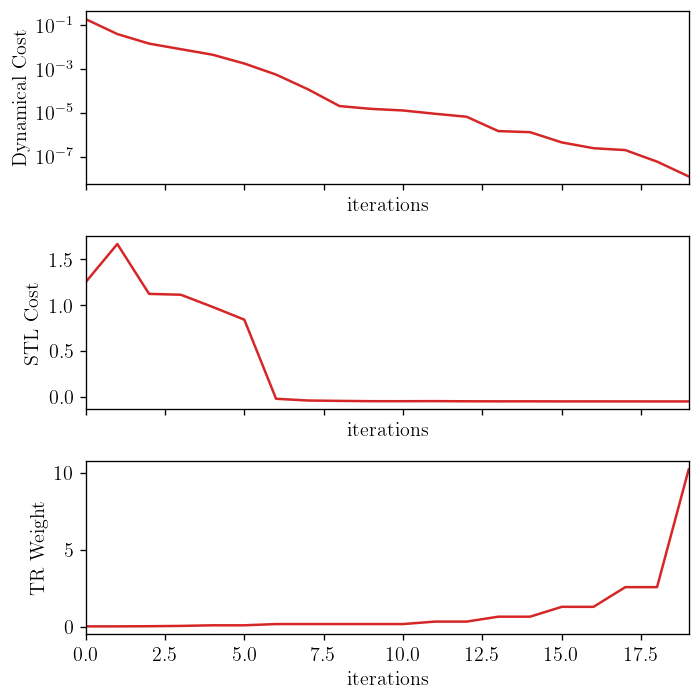

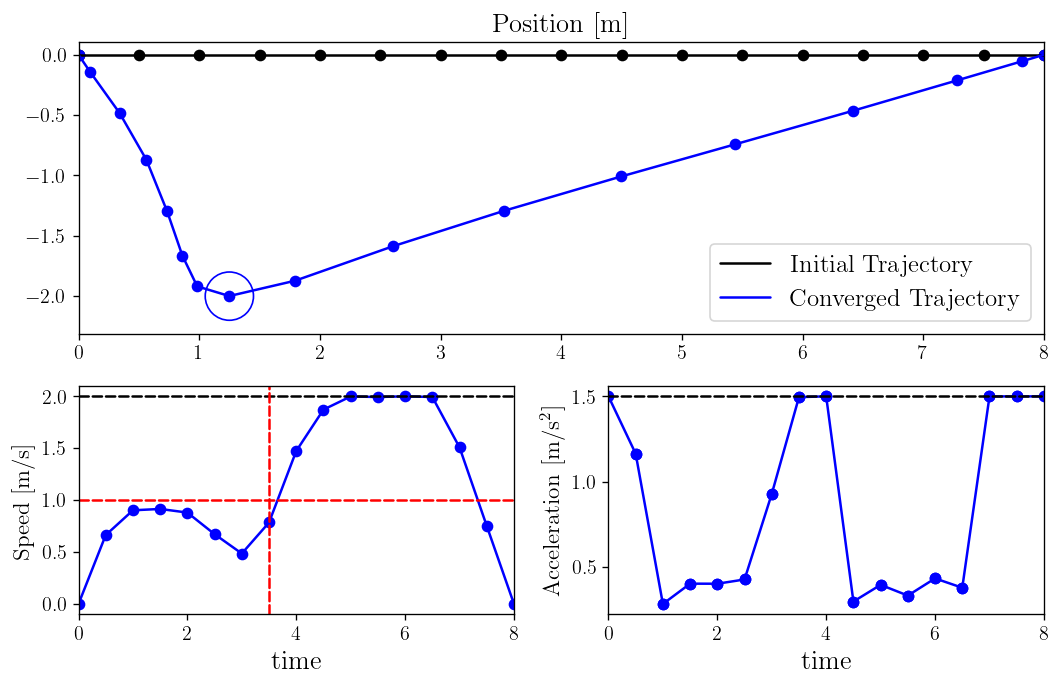

In [20]:
if 'run_nonlinear_double_integrator' in run_list:
    ndi_params0 = ndi_params_fcn()
    ndi_params = ndi_dynamics(ndi_params0.copy())
    ndi_params['vehicle_cost_fcn'] = ndi_cost_fcn
    ndi_params['vehicle_cons_fcn'] = ndi_cons_fcn

    ndi_results = RUN(ndi_params.copy())

    plot_cost(ndi_results, ndi_params, vehicle='ndi')
    ndi_plot(ndi_results, ndi_params, save_fig, fig_format, fig_png_dpi)

### Quadrotor flight

100%|██████████| 100/100 [00:00<00:00, 3965.57it/s]


Dynamical Cost 9.639012336202864e-06
STL Cost -0.07843457811480237
TR Weight 1.28


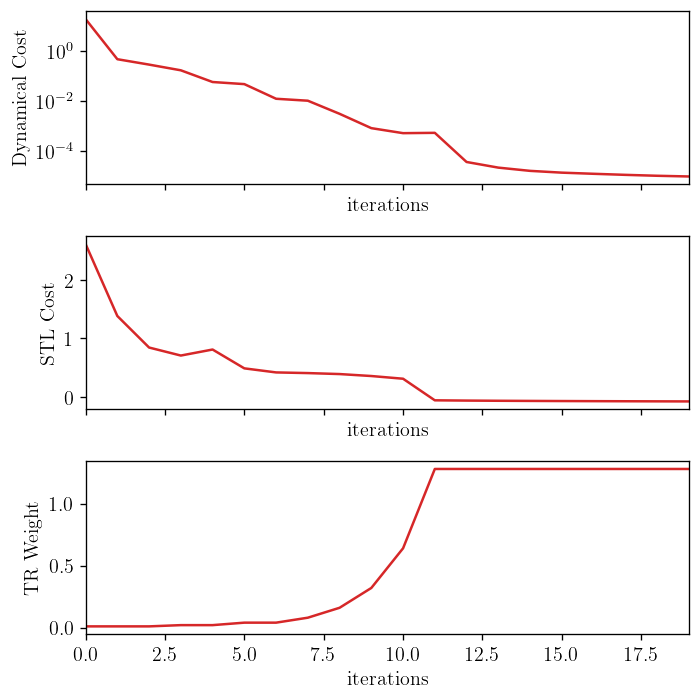

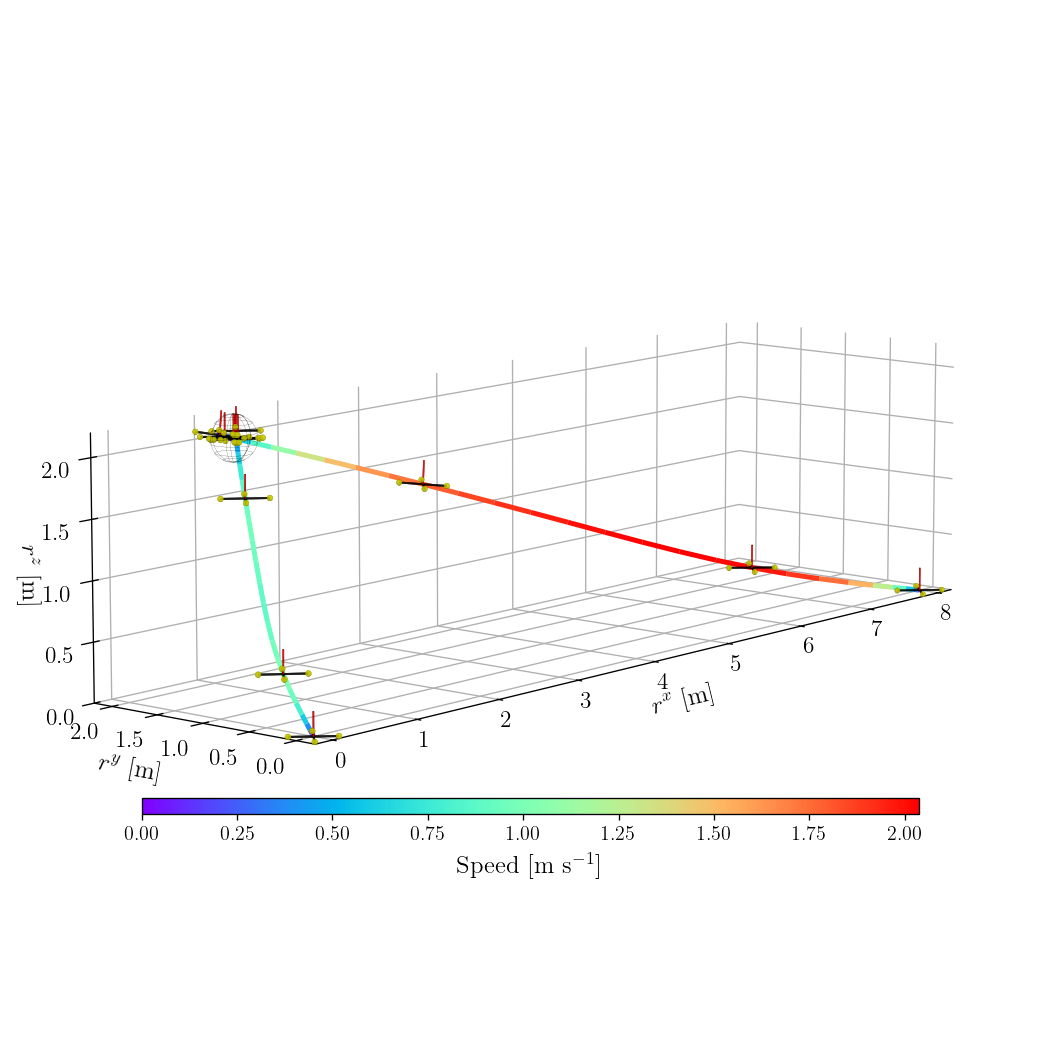

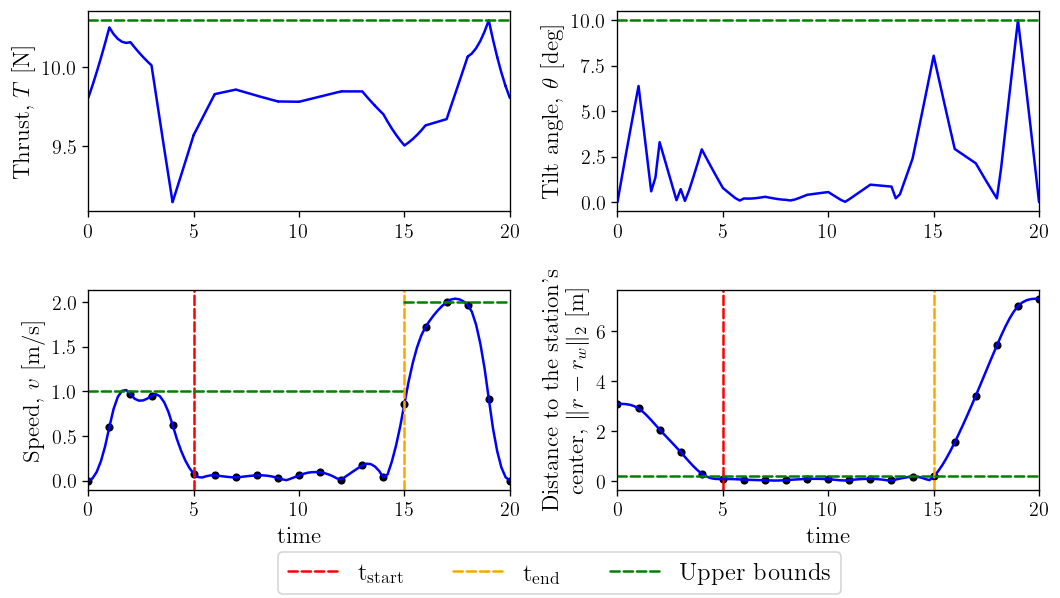

In [21]:
if 'run_quadrotor_flight' in run_list:
    qf_params0 = qf_params_fcn()
    qf_params = qf_dynamics(qf_params0.copy())
    qf_params['vehicle_cost_fcn'] = qf_cost_fcn
    qf_params['vehicle_cons_fcn'] = qf_cons_fcn

    qf_results = RUN(qf_params.copy())

    plot_cost(qf_results, qf_params, vehicle='qf')
    qf_plot(qf_results, qf_params, save_fig, fig_format, fig_png_dpi)

### Autonomous Rocket Landing

100%|██████████| 200/200 [00:00<00:00, 1787.57it/s]


Dynamical Cost 1.1759679724289924e-05
STL Cost 5.935220315222978e-09
TR Weight 64.0


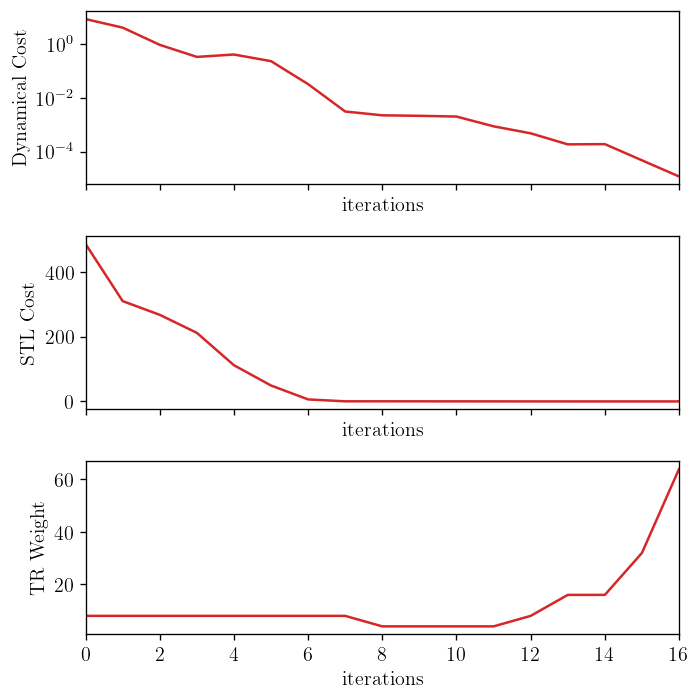

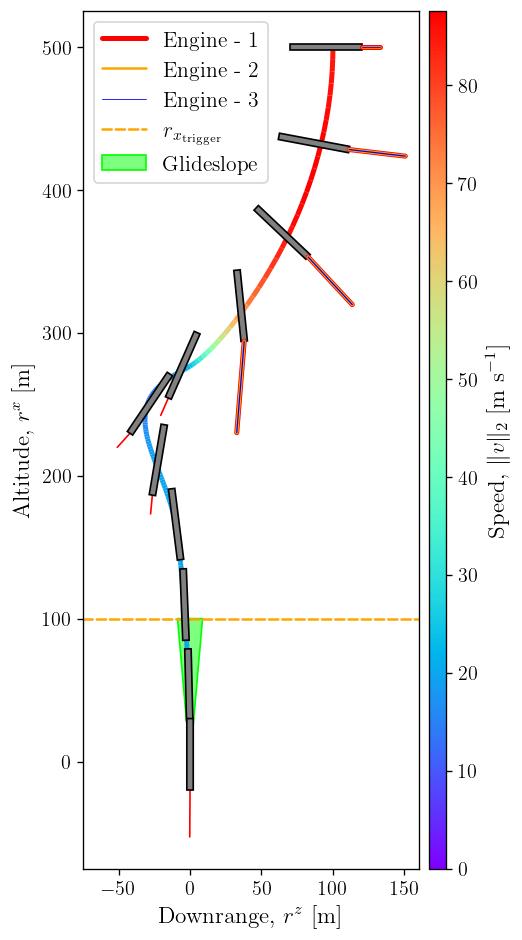

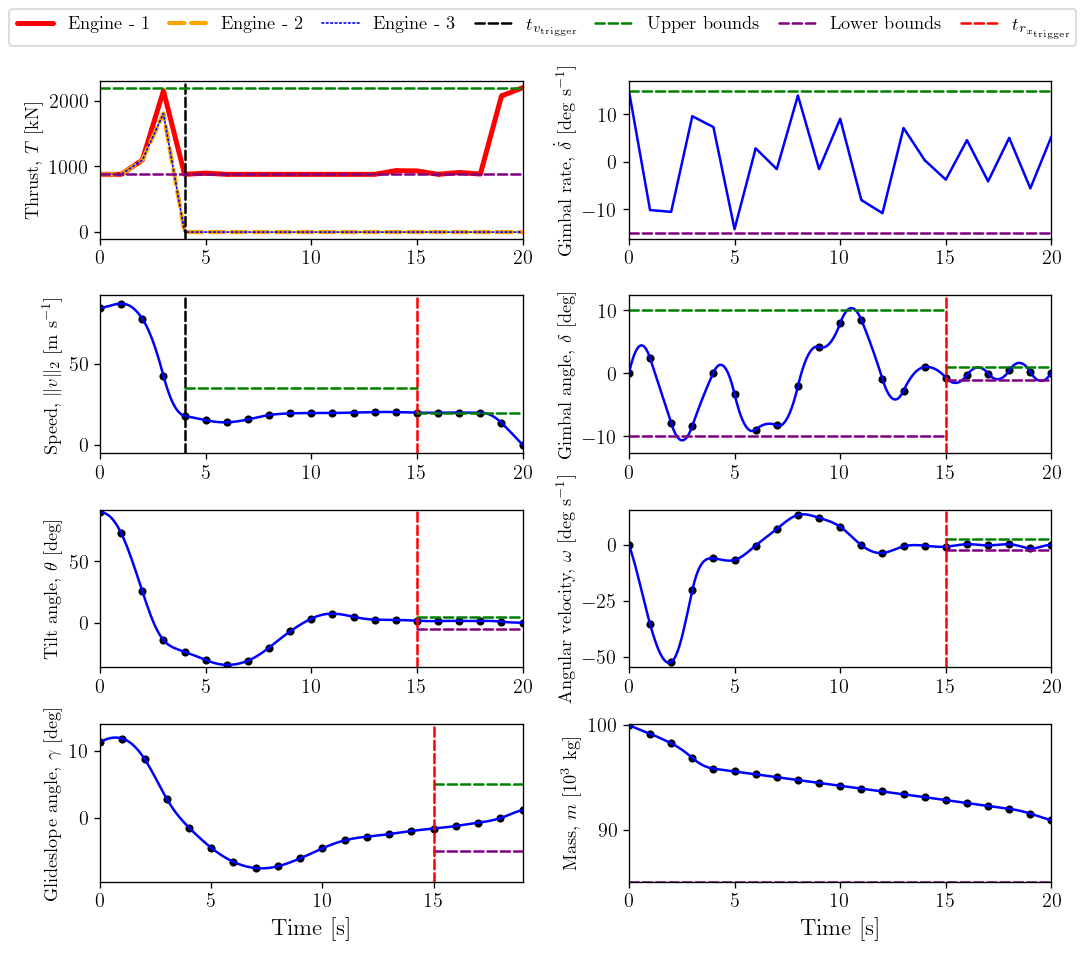

In [22]:
if 'run_rocket_landing' in run_list:
    rl_params = rl_params_fcn()
    rl_params_sc = scale_params(rl_params.copy())

    rl_params_sc = rl_dynamics(rl_params_sc.copy())
    rl_params_sc['vehicle_cost_fcn'] = rl_cost_fcn
    rl_params_sc['vehicle_cons_fcn'] = rl_cons_fcn

    rl_results_sc = RUN(rl_params_sc.copy())
    rl_results = unscale_results(rl_results_sc.copy(), rl_params.copy())

    plot_cost(rl_results, rl_params, vehicle='rl')
    rl_plot(rl_results, rl_params, rl_animations, save_fig, fig_format, fig_png_dpi)
    if rl_animations: 
        make_gif('sim/')
